In [1]:
from prevo.record import SensorBase, ControlledProperty
from prevo.record.numerical import NumericalRecording, NumericalRecord
from prevo.record.images import ImageRecording, ImageRecord
from prevo.misc import DummyPressureSensor, DummyTemperatureSensor, DummyLapseCamera

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib tk

In this notebook we will see how to use `prevo.record` classes to record periodically:
- sensors providing numerical data (e.g. temperature sensors, etc.)
- sensors providing images (e.g. cameras)

# Record numerical sensors
(e.g. pressure, temperature, etc.)

## Define sensors

We assume that the user already has sensors and a way to interact with it in Python. Here, We use dummy sensors as examples:

In [2]:
psensor = DummyPressureSensor()
tsensor = DummyTemperatureSensor()
tsensor.read(avg=10)  # avg=10 averages over 10 successive measurements

{'T1 (°C)': 25.159532984280975, 'T2 (°C)': 22.439244923190707}

Now we subclass `SensorBase` to put the reading of these sensors in a framework that is usable by `prevo.record` classes and functions.

In [3]:
class Sensor(SensorBase):
    """Provide methods common to all sensors.
    
    NOTE: the __init__() of SensorBase provides error management by 
    catching any Exception. If redefining __init__, be careful to
    call SensorBase.__init__() or to redefine self.exceptions.
    """
    
    def  _get_data(self):
        """Automatically add time and time uncertainty in data dict.
        
        If one does not want to add time info to measurements, or if one
        wants to use time info from the sensors themselves, the method
        _read() must be subclassed instead of _get_data().
        """
        measurement = self.device.read(avg=self.avg)
        return tuple(measurement.values())
    

# We want do control the averaging of the data in real time from the CLI
# To do so, we'll defined a ControlledProperty object. It can then be
# indicated either in Sensor or Recording classes in self.controlled_properties
# to indicate that one wants to control averaging of that particular sensor.
# Here we will provide real-time averaging options only for pressure.
# NOTE: any sensor/recording property (attribute) can be controlled by CLI.

averaging = ControlledProperty(attribute='avg',                # Sensor attribute to control
                               readable='Averaging',           # Human-readable info of ppty
                               commands=('avg', 'averaging'))  # how to access ppty in CLI
                           

                               
class PressureSensor(Sensor):
    
    name = 'P'
    
    # This will be the names of columns in the CSV file
    # (as can be seen below, time columns are also added automatically)
    column_names = 'P1', 'P2', 'P3'
    
    # data_types is useful only when using live graphs
    data_types = 'P (Pa)', 'P (Pa)', 'P (mbar)'
    
    # Name of csv/tsv file into which data will be saved for this sensor
    filename = 'Pressure.tsv'
                               
    controlled_properties = (averaging,)
    
    def __init__(self):
        super().__init__()  # see comment in Sensor docstring above
        self.device = DummyPressureSensor()
        self.avg = 10  # by default, averaging is


class TemperatureSensor(Sensor):
    
    name = 'T'
    column_names = 'T1', 'T2'
    data_types = 'T (°C)', 'T (°C)'
    filename = 'Temperature.csv'
    
    def __init__(self):
        super().__init__()
        self.device = DummyTemperatureSensor()
        self.avg = 1  # this will stay fixed

In [4]:
# Sensor automatically adds a context manager that can be tuned.
with PressureSensor() as sensor:
    data = sensor.read()
data

{'values': (3170.5040122531386, 2338.8925497039895, 17.3075980682487),
 'time (unix)': 1691675518.6850953,
 'dt (s)': 0.00013800000306218863}

## Define recordings / record objects

Here we're going to subclass `NumericalRecording` and `NumericalRecord` classes for easier use, in particular to define automatically the properties of the recordings depending on the input sensors.

In [5]:
class Recording(NumericalRecording):
    
    def __init__(self, Sensor, **kwargs):
        """kwargs will be useful later to include options such as programs (see below)"""
        
        # time and uncertainty on time are automatically added when reading the sensor
        # so one must also adds them to the column names.
        column_names = ('time (unix)', 'time uncertainty (s)') + Sensor.column_names
        
        super().__init__(Sensor=Sensor,
                         filename=Sensor.filename,
                         column_names=column_names,
                         path='data',
                         **kwargs)
        
# If one wants real-time graphing options with NumericalReord, one must supply a dict of
# the data types of each channel of each sensor. On the graph, there will be as many
# windows (frames) as different data types, and all values will the same data type will
# be in the same window/frame.
# This dict can contain more keys than the name of the sensors in a given record.
sensors = PressureSensor, TemperatureSensor
data_types = {Sensor.name: Sensor.data_types for Sensor in sensors}


class Record(NumericalRecord):
    
    def __init__(self, recordings):
        """If data_types not supplied, graphing options are not available"""
        super().__init__(recordings,
                         data_types=data_types,
                         path='data')

## Start recording

**IMPORTANT NOTE**: Below, by default recordings are OFF (`on=False`) option. After starting the recording, turn them on by typing `on True` in the CLI

**Other important NOTE**: Real-time numerical graphs can be triggered from the CLI with the command `g`. In some situations, making any input in the CLI when the graph is active makes the program crash. If this hapens, close the graph window first, make the desired input in the CLI, and open the graph again.

In [6]:
recordings = Recording(PressureSensor), Recording(TemperatureSensor)
record = Record(recordings)
record.start(dt=3, dt_P=0.5, on=False)





Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples/data


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  on True


New Rec. ON for P: True
New Rec. ON for T: True


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  ?


OBJECTS ========================================================================
--- P [Recording (P)]
        Δt (s)
        Rec. ON
        Averaging
--- T [Recording (T)]
        Δt (s)
        Rec. ON
COMMANDS =======================================================================
--- Properties
        dt -- Δt (s) [interval]
        avg, averaging -- Averaging [sensor.avg]
        on -- Rec. ON [active]
--- Events
        g, graph -- graph
--- Exit
        q, Q, quit
EXAMPLE ========================================================================
dt-P xx -- change Δt (s) to xx for P only
dt xx -- change Δt (s) to xx for all relevant objects


Type command (help: ?):  q


CLI stopped
Recording Stopped


In [7]:
pressure_data = pd.read_csv('data/Pressure.tsv', sep='\t')
pressure_data.head()

,time (unix),time uncertainty (s),P1,P2,P3
0,1.690973e+09,0.000249,3170.622582,2339.590368,17.321436
1,1.690973e+09,0.000152,3170.502831,2339.103557,17.231795
2,1.690973e+09,0.000155,3170.614607,2338.923803,17.278305
3,1.690973e+09,0.000114,3170.305818,2339.074648,17.315095
4,1.690973e+09,0.000176,3170.291133,2339.079034,17.305934


<Axes: xlabel='time (unix)'>

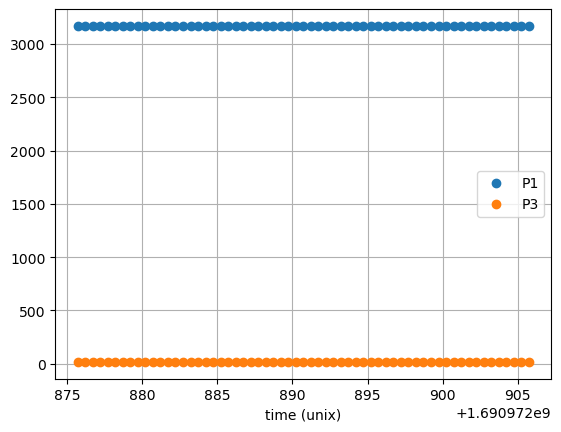

In [8]:
# Note: time is unix time
pressure_data.plot(x='time (unix)', y=['P1', 'P3'], style='o', grid=True)

## Programmable recording

It is possible to program recording properties, for example to change automatically the time interval between data points after some time, or to start / stop recording certain sensors at given times.

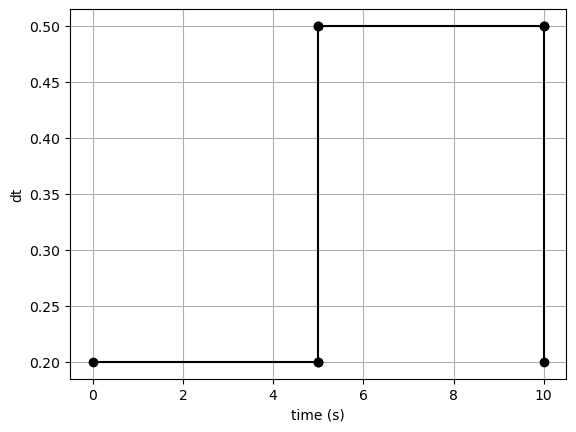

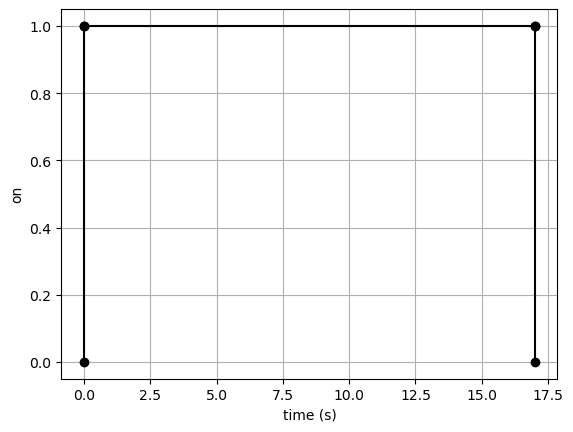

In [10]:
from prevo.control import Program, Stairs

prog_dt = Stairs(duration='::5', dt=[0.2, 0.5])
prog_on = Program(durations=('::', '::17', '::'), on=[False, True, True])

prog_dt.plot(time_unit='s')
prog_on.plot(time_unit='s')

**NOTE** When using programs that modify the sampling time interval (`dt`), it can be desirable to use the `immediate=False` option, which prevents changes in the timer to be taken into account immediately. Using this option can prevent to have arbitrary time intervals in the data (which occur because changes in time interval occur at random points during a waiting phase). However, one must then also take care to set the initial `dt` of each sensor impacted by the program to the initial `dt` of the program, in order to prevent varying time intervals at the beginning of recording.

**NOTE** The precision of time interval between data points can be improved with the `precise=True` option.

In [14]:
# With these options, the time interval of the pressure recording will oscillate
# between 0.2 and 0.5 seconds every 5 seconds, and both recordings will stop
# after 17 seconds.

recordings = (
    Recording(PressureSensor, programs=(prog_on, prog_dt), immediate=False, precise=True),
    Recording(TemperatureSensor, programs=(prog_on,)),
)
Record(recordings).start(dt_P=0.2)



Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples/data
[2023-08-02 12:44:18] ------ PROGRAM (on)--- NEW CYCLE 1 / 1

[2023-08-02 12:44:18] ------ PROGRAM (dt)--- NEW CYCLE 1 / 1

[2023-08-02 12:44:18] ------ PROGRAM (on)--- NEW CYCLE 1 / 1

[2023-08-02 12:44:30] ------ PROGRAM (dt)--- FINISHED

[2023-08-02 12:44:37] ------ PROGRAM (on)--- FINISHED
[2023-08-02 12:44:37] ------ PROGRAM (on)--- FINISHED




Type command (help: ?):  q


CLI stopped
Recording Stopped


<Axes: xlabel='time (unix)'>

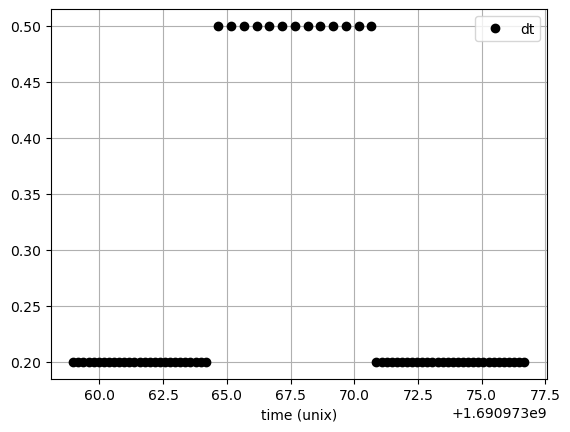

In [15]:
pressure_data = pd.read_csv('data/Pressure.tsv', sep='\t')
pressure_data['dt'] = pressure_data['time (unix)'].diff()
pressure_data.plot(x='time (unix)', y='dt', style='ok', grid=True)

# Record images (cameras)

We assume that the user already has a source of image (e.g. a camera) and is able to interact with it in Python to get images. Here we use a dummy camera sensor that returns random images and an associate timestamp (unix time)

In [2]:
cam = DummyLapseCamera()
cam.read()

{'image': array([[182, 197, 115, ...,  58,  33, 161],
        [ 99, 151,  76, ...,  75,  35, 116],
        [184,  73, 100, ..., 153,  73,  22],
        ...,
        [ 83,  64, 144, ...,  98, 158, 233],
        [206,  74,  84, ...,  60, 129, 184],
        [179, 151,  74, ...,  56,  25, 137]], dtype=uint8),
 'timestamp': 1691675592.742827}

Similarly as above, we can subclass `SensorBase`, `ImageRecording` and `ImageRecord`. We will define two camera sensors and record them at the same time.

In [3]:
class CameraSensor(SensorBase):
    """Provide methods common to all camera sensors"""
    
    def __init__(self):
        super().__init__()
        self.camera = DummyLapseCamera()
        
    def  _read(self):
        """Here we don't want to use _get_data() but _read(), since the 
        sensor provides its own timestamps."""
        
        # Note: here, the camera returns immediately a dict with 'image'
        # as key. If it's not the case, one should make sure here to add
        # a line to return a dict with the image array at the key 'image'
        return self.camera.read()
    

class Cam1(CameraSensor):
    name = 'Cam1'


class Cam2(CameraSensor):
    name = 'Cam2'
    
    
# Again, the SensorBase class provides a context manager that can be tuned if necessary
with Cam2() as camera:
    data = camera.read()
data['timestamp']

1691675595.1439533

In [4]:
class CamRecording(ImageRecording):
    
    def __init__(self, Sensor, **kwargs):
        """kwargs can include programs, precision options etc. (see above)"""
        super().__init__(Sensor,
                         timestamp_filename=f'{Sensor.name}_timestamps.tsv',
                         # Below: include 'filename' if you want the name of the image in the
                         # timestamp file. Any other column name must be generated as a key 
                         # in the dict returned by CameraSensor._read().
                         column_names=('filename', 'timestamp',),
                         path='data',
                         **kwargs)
        self.name = Sensor.name
        

class CamRecord(ImageRecord):
    
    def __init__(self, recordings, viewer='tk'):
        """Here we do not include programs, but it's possible to pass them as well
        (e.g. to create temporal variations of fps or interval between images, etc."""
        super().__init__(recordings, path='data', viewer=viewer)

**NOTE**: Here, pressing `g` in the CLI will trigger a live view of the images. Three viewers are available for now (Tkinter, Matplotlib, OpenCV). They can be changed in the `viewer=` option (with `'tk'`, `'mpl'` or `'cv'` respectively). Some might not work on certain machines and/or with certain backends. It is also possible to use your own viewer by redefining `ImageRecord.data_plot()`

In [5]:
# The precise=True option can improve precision of time intervals significantly (~ms instead of ~10ms)

recordings = (
    CamRecording(Cam1, precise=True),
    CamRecording(Cam2),
)

# Here, we specify two different time intervals to read images for each camera
CamRecord(recordings, viewer='tk').start(dt_Cam1=0.33, dt_Cam2=0.3)





Recording started in folder /Users/olivier.vincent/Python-OV/prevo/examples/data


Type command (help: ?):  ?


OBJECTS ========================================================================
--- Cam1 [CamRecording (Cam1)]
        Δt (s)
        Rec. ON
--- Cam2 [CamRecording (Cam2)]
        Δt (s)
        Rec. ON
COMMANDS =======================================================================
--- Properties
        dt -- Δt (s) [interval]
        on -- Rec. ON [active]
--- Events
        g, graph -- graph
--- Exit
        q, Q, quit
EXAMPLE ========================================================================
dt-Cam1 xx -- change Δt (s) to xx for Cam1 only
dt xx -- change Δt (s) to xx for all relevant objects


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  g


Graph event requested


Type command (help: ?):  q


CLI stopped
Recording Stopped


Text(0, 0.5, '$\\Delta t$ (s)')

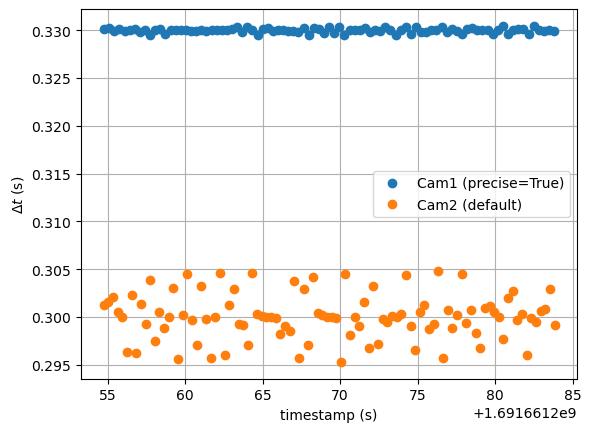

In [8]:
cam1_data = pd.read_csv('data/Cam1_timestamps.tsv', sep='\t')
cam2_data = pd.read_csv('data/Cam2_timestamps.tsv', sep='\t')

fig, ax = plt.subplots()
labels = 'Cam1 (precise=True)', 'Cam2 (default)'
all_data = cam1_data, cam2_data

for data, label in zip(all_data, labels): 
    data['dt'] = data['timestamp'].diff()
    ax.plot(data['timestamp'], data['dt'], 'o', label=label)
    
ax.grid()
ax.legend()
ax.set_xlabel('timestamp (s)')
ax.set_ylabel(r'$\Delta t$ (s)')

# Final remarks

Everything is customizable, e.g. more specific error management, usage of personal data viewing tools (graphs, image viewers, etc.),programmable recordings, sensor properties controlled by the CLI, etc. For more information, read the docstrings in `prevo.record`, `prevo.record.numerical` and `prevo.record.images`